In [1]:
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import (
    RandomForestClassifier,
    StackingClassifier,
)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    train_test_split,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from tqdm import tqdm
from xgboost import XGBClassifier

warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)

In [2]:
tqdm.pandas()

---

<center><h1>💻💻 Classifier Model 💻 💻</h1></center>

---

In [3]:
# Invoking the prepared data

df = pd.read_csv('working.csv')

In [4]:
df.dtypes

CO(GT)_winsor          float64
PT08.S1(CO)_winsor     float64
PT08.S4(NO2)_winsor    float64
T_winsor               float64
RH_winsor              float64
AH_winsor              float64
day_winsor             float64
year_winsor            float64
quarter_winsor         float64
weekday_winsor         float64
NO2(GT)_winsor         float64
air_quality             object
dtype: object

In [5]:
le = LabelEncoder()
df['air_quality'] = le.fit_transform(df['air_quality'])

In [6]:
df.shape

(8421, 12)

## Splitting the set into training and validation sets

In [7]:
train_X = df.drop(['NO2(GT)_winsor', 'air_quality'], axis=1)

In [8]:
train_y = df['air_quality']

In [9]:
RANDOM_SEED = 16092023

In [10]:
# Let’s split X and y using Train validation split
X_train, X_validation, y_train, y_validation = train_test_split(
    train_X, train_y, train_size=0.8, random_state=RANDOM_SEED, stratify=train_y
)

# get shape of train and test data
print("train data size:", X_train.shape)
print("test data size:", X_validation.shape)

train data size: (6736, 10)
test data size: (1685, 10)


We note that the proportion of classes is preserved:

In [11]:
train_y.value_counts(normalize=True)*100, y_train.value_counts(normalize=True)*100, y_validation.value_counts(normalize=True)*100

(air_quality
 0    64.398527
 2    29.177057
 1     6.424415
 Name: proportion, dtype: float64,
 air_quality
 0    64.400238
 2    29.171615
 1     6.428147
 Name: proportion, dtype: float64,
 air_quality
 0    64.391691
 2    29.198813
 1     6.409496
 Name: proportion, dtype: float64)

## Classifier Models

The function cv_score_classifier is designed to perform cross-validation for classification models. As is well-known, cross-validation is a technique used to assess the generalization performance of a model on unseen data. This function specifically applies K-Fold cross-validation, which is a commonly used method in machine learning.

In [12]:
def cv_score_classifier(ml_model, rstate=11, cols=None, df=None, df_y=None):
    start_time = time.time()

    if df is None or df_y is None:
        raise ValueError("DataFrames df and df_y must be provided")

    if cols is not None:
        df1 = df[cols].copy()
    else:
        df1 = df.copy()

    cv_scores = []
    
    kf = KFold(n_splits=5, random_state=rstate, shuffle=True)
    
    for train_index, test_index in kf.split(df1):
        xtr, xvl = df1.iloc[train_index], df1.iloc[test_index]
        ytr, yvl = df_y.iloc[train_index], df_y.iloc[test_index]

        model = ml_model
        model.fit(xtr, ytr)
        pred_val = model.predict(xvl)
        
        # Calculate accuracy for classification
        score = accuracy_score(yvl, pred_val)
        
        # Save scores
        cv_scores.append(score)

    end_time = time.time()
    
    print(f"Duration for training the model: {end_time - start_time:.2f} seconds.")
    print(f"Average accuracy score across folds: {np.mean(cv_scores):.4f}")
    return cv_scores

In [13]:
random_forest_classifier = cv_score_classifier(RandomForestClassifier(n_estimators=100, random_state=20230916), df = X_train, df_y = y_train)

Duration for training the model: 4.01 seconds.
Average accuracy score across folds: 0.8441


In [14]:
k_neighbors_classifier = cv_score_classifier(KNeighborsClassifier(n_neighbors=3), df = X_train, df_y = y_train)

Duration for training the model: 0.39 seconds.
Average accuracy score across folds: 0.8131


In [15]:
decision_tree_classifier = cv_score_classifier(DecisionTreeClassifier(random_state=20230916), df = X_train, df_y = y_train)

Duration for training the model: 0.17 seconds.
Average accuracy score across folds: 0.7895


In [16]:
xgb_classifier = cv_score_classifier(XGBClassifier(random_state=20230916), df = X_train, df_y = y_train)

Duration for training the model: 1.23 seconds.
Average accuracy score across folds: 0.8400


In [17]:
dictionary_classifier = {
    "RandomForestClassifier": random_forest_classifier,
    "KNeighborsClassifier": k_neighbors_classifier,
    "DecisionTreeClassifier": decision_tree_classifier,
    "XGBClassifier": xgb_classifier,
}

In [18]:
results_df = pd.DataFrame(dictionary_classifier)

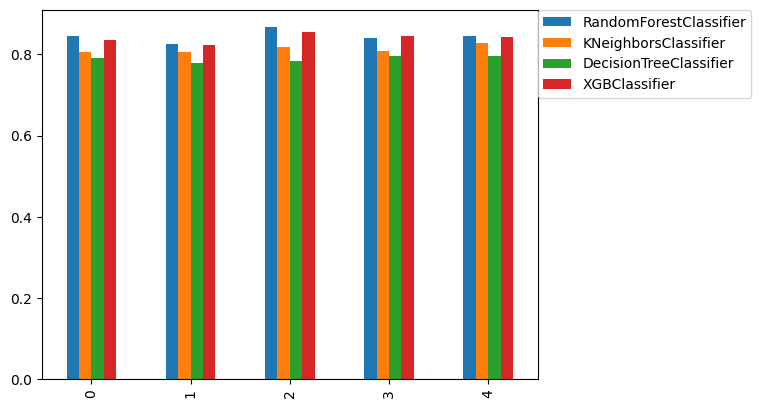

In [19]:
results_df.plot(y=list(dictionary_classifier), kind="bar", legend=False)
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
plt.show()

## Stacking model

We now see the performance of the combination of the models:

In [20]:
# Base models
estimators = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=20230916)),
    ('knr', KNeighborsClassifier(n_neighbors=3)),
    ('dt', DecisionTreeClassifier(random_state=20230916)),
    ('xgb', XGBClassifier(random_state=20230916)),
]

# Meta-model
meta_model = LogisticRegression()

# Stacking classifier
stacking_clf = StackingClassifier(estimators=estimators, 
                                  final_estimator=meta_model,
                                  cv=5)

# Fit the model
stacking_clf.fit(X_train, y_train)

# Make predictions
y_pred = stacking_clf.predict(X_validation)

We now inroduce a classification metrics definition, which it will help us to understand the performance of each model.

In [21]:
def print_classification_metrics(y_true, y_pred, model_name="Model"):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    print(f"{model_name} Metrics on Validation Set:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1 Score: {f1:.4f}")
    print("-" * 40)
    print("Classification Report:")
    print(classification_report(y_true, y_pred))

In [22]:
y_pred_stack = stacking_clf.predict(X_validation)
print_classification_metrics(y_validation, y_pred_stack, model_name="Stacking Classifier")

for name, model in estimators:
    model.fit(X_train, y_train)  # Fit the base model on the training data
    y_pred = model.predict(X_validation)  # Predict on the validation data
    print_classification_metrics(y_validation, y_pred, model_name=name)

Stacking Classifier Metrics on Validation Set:
  Accuracy: 0.8427
  Precision: 0.8395
  Recall: 0.8427
  F1 Score: 0.8407
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90      1085
           1       0.62      0.51      0.56       108
           2       0.78      0.77      0.77       492

    accuracy                           0.84      1685
   macro avg       0.76      0.73      0.74      1685
weighted avg       0.84      0.84      0.84      1685

rf Metrics on Validation Set:
  Accuracy: 0.8445
  Precision: 0.8418
  Recall: 0.8445
  F1 Score: 0.8428
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90      1085
           1       0.65      0.56      0.60       108
           2       0.78      0.77      0.78       492

    accuracy                           0.84   

We observe that stacking several models provide a final predictor model. However, one of the limitations of stacking is that it is not possible to verify the feature importances behind the model.

# Hyperparameter Tunning

In [23]:
RANDOM_SEED = 20230916

## RandomForestClassifier

In [24]:
# RandomForestClassifier
rf = RandomForestClassifier(random_state=RANDOM_SEED)
param_grid_forest = {
    "n_estimators": [100, 200, 300],
    "max_depth": [5, 10, 15],
    "max_leaf_nodes": [50, 100],
}

grid_forest = GridSearchCV(
    estimator=rf, param_grid=param_grid_forest, cv=5, n_jobs=-1, scoring="accuracy", verbose=0
)

model_forest = grid_forest.fit(X_train, y_train)

The associated metrics to the model are:

In [25]:
# Extract the best parameters for RandomForestClassifier
best_params_forest = grid_forest.best_params_

# Train the model with the best parameters
best_model_forest = RandomForestClassifier(**best_params_forest, random_state=RANDOM_SEED)
best_model_forest.fit(X_train, y_train)

# Make predictions on the validation set
y_pred_forest = best_model_forest.predict(X_validation)

# Calculate and print metrics
print_classification_metrics(y_validation, y_pred_forest, model_name="RandomForestClassifier")

RandomForestClassifier Metrics on Validation Set:
  Accuracy: 0.8113
  Precision: 0.8047
  Recall: 0.8113
  F1 Score: 0.8066
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.91      0.88      1085
           1       0.61      0.47      0.53       108
           2       0.73      0.67      0.70       492

    accuracy                           0.81      1685
   macro avg       0.73      0.68      0.70      1685
weighted avg       0.80      0.81      0.81      1685



## KNeighborsClassifier

In [26]:
# KNeighborsClassifier
knc = KNeighborsClassifier()
param_grid_knc = {
    "n_neighbors": [3, 5, 7],
    "weights": ["uniform", "distance"],
    "algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
}

grid_knc = GridSearchCV(
    estimator=knc, param_grid=param_grid_knc, cv=5, n_jobs=-1, scoring="accuracy", verbose=0
)

model_knc = grid_knc.fit(X_train, y_train)

The associated metrics to the model are:

In [27]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Step 1: Extract the best parameters for KNeighborsClassifier
best_params_knc = grid_knc.best_params_

# Step 2: Train the model with the best parameters
best_model_knc = KNeighborsClassifier(**best_params_knc)
best_model_knc.fit(X_train, y_train)

# Step 3: Make predictions on the validation set
y_pred_knc = best_model_knc.predict(X_validation)

# Print the metrics for the KNeighborsClassifier
print_classification_metrics(y_validation, y_pred_knc, model_name="KNeighborsClassifier")

KNeighborsClassifier Metrics on Validation Set:
  Accuracy: 0.8160
  Precision: 0.8132
  Recall: 0.8160
  F1 Score: 0.8144
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.90      0.89      1085
           1       0.52      0.49      0.50       108
           2       0.74      0.71      0.73       492

    accuracy                           0.82      1685
   macro avg       0.71      0.70      0.71      1685
weighted avg       0.81      0.82      0.81      1685



## DecisionTreeClassifier

In [28]:
dt = DecisionTreeClassifier(random_state=RANDOM_SEED)
param_grid_dt = {
    "max_depth": [5, 10, 15],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_leaf_nodes": [50, 100, None],
}

grid_dt = GridSearchCV(
    estimator=dt, param_grid=param_grid_dt, cv=5, n_jobs=-1, scoring="accuracy", verbose=0
)

model_dt = grid_dt.fit(X_train, y_train)

In [29]:
best_params_dt = grid_dt.best_params_

best_model_dt = DecisionTreeClassifier(**best_params_dt, random_state=RANDOM_SEED)
best_model_dt.fit(X_train, y_train)

y_pred_dt = best_model_dt.predict(X_validation)

print_classification_metrics(y_validation, y_pred_dt, model_name="DecisionTreeClassifier")

DecisionTreeClassifier Metrics on Validation Set:
  Accuracy: 0.8148
  Precision: 0.8188
  Recall: 0.8148
  F1 Score: 0.8163
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.88      0.88      1085
           1       0.52      0.65      0.58       108
           2       0.73      0.70      0.72       492

    accuracy                           0.81      1685
   macro avg       0.71      0.74      0.73      1685
weighted avg       0.82      0.81      0.82      1685



## XGBClassifier

In [30]:
xgb = XGBClassifier(random_state=RANDOM_SEED)
param_grid_xgb = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.2],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
}

grid_xgb = GridSearchCV(
    estimator=xgb, param_grid=param_grid_xgb, cv=5, n_jobs=-1, scoring="accuracy", verbose=0
)

model_xgb = grid_xgb.fit(X_train, y_train)

In [31]:
best_params_xgb = grid_xgb.best_params_

best_model_xgb = XGBClassifier(**best_params_xgb, random_state=RANDOM_SEED)
best_model_xgb.fit(X_train, y_train)

y_pred_xgb = best_model_xgb.predict(X_validation)

print_classification_metrics(y_validation, y_pred_xgb, model_name="XGBClassifier")

XGBClassifier Metrics on Validation Set:
  Accuracy: 0.8487
  Precision: 0.8474
  Recall: 0.8487
  F1 Score: 0.8479
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.91      0.90      1085
           1       0.64      0.56      0.60       108
           2       0.77      0.79      0.78       492

    accuracy                           0.85      1685
   macro avg       0.77      0.75      0.76      1685
weighted avg       0.85      0.85      0.85      1685



## Comparing visually the different models

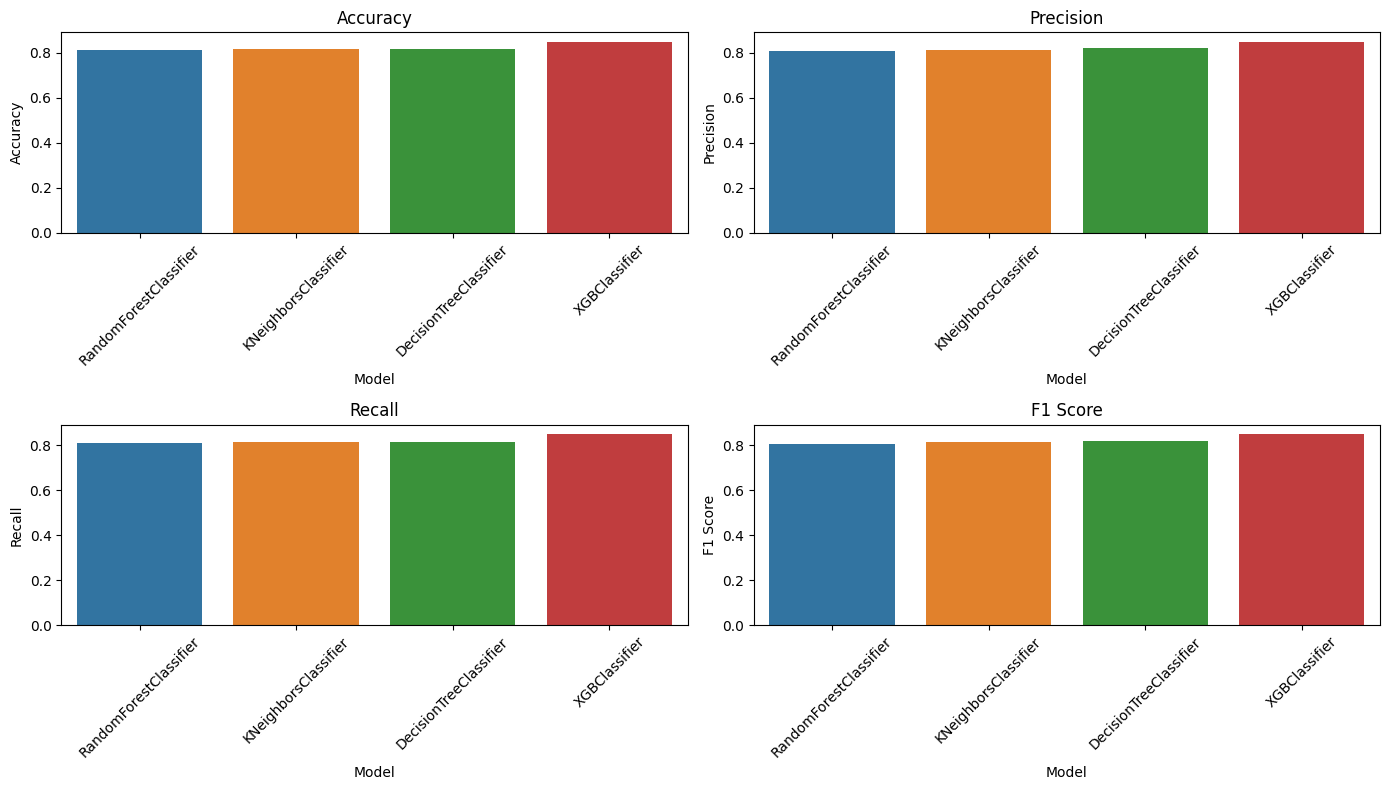

In [32]:
model_names = []
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []

def calculate_and_store_metrics(model_name, y_true, y_pred):
    model_names.append(model_name)
    accuracy_scores.append(accuracy_score(y_true, y_pred))
    precision_scores.append(precision_score(y_true, y_pred, average='weighted'))
    recall_scores.append(recall_score(y_true, y_pred, average='weighted'))
    f1_scores.append(f1_score(y_true, y_pred, average='weighted'))
    
calculate_and_store_metrics("RandomForestClassifier", y_validation, y_pred_forest)
calculate_and_store_metrics("KNeighborsClassifier", y_validation, y_pred_knc)
calculate_and_store_metrics("DecisionTreeClassifier", y_validation, y_pred_dt)
calculate_and_store_metrics("XGBClassifier", y_validation, y_pred_xgb)

metrics_df = pd.DataFrame({
    "Model": model_names,
    "Accuracy": accuracy_scores,
    "Precision": precision_scores,
    "Recall": recall_scores,
    "F1 Score": f1_scores
})

# Set up the matplotlib figure
plt.figure(figsize=(14, 8))

# Plot Accuracy
plt.subplot(2, 2, 1)
sns.barplot(x="Model", y="Accuracy", data=metrics_df)
plt.title("Accuracy")
plt.xticks(rotation=45)

# Plot Precision
plt.subplot(2, 2, 2)
sns.barplot(x="Model", y="Precision", data=metrics_df)
plt.title("Precision")
plt.xticks(rotation=45)

# Plot Recall
plt.subplot(2, 2, 3)
sns.barplot(x="Model", y="Recall", data=metrics_df)
plt.title("Recall")
plt.xticks(rotation=45)

# Plot F1 Score
plt.subplot(2, 2, 4)
sns.barplot(x="Model", y="F1 Score", data=metrics_df)
plt.title("F1 Score")
plt.xticks(rotation=45)

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

We note that in fact, the XGBClassifier model has the best performance.

## Test set performance of the models

For the test set we verify our results in order to avoid overfitting of bad choices of the best models.

In [33]:
# Invoking the prepared data

df_test = pd.read_csv('test.csv')

In [34]:
X_test = df_test.drop(['NO2(GT)_winsor', 'air_quality'], axis=1)

In [35]:
y_test = df_test['air_quality']

In [36]:
le = LabelEncoder()
y_test = le.fit_transform(y_test)

In [37]:
y_test_pred_forest = best_model_forest.predict(X_test)
print_classification_metrics(y_test, y_test_pred_forest, model_name="RandomForestClassifier")

# KNeighborsClassifier
y_test_pred_knc = best_model_knc.predict(X_test)
print_classification_metrics(y_test, y_test_pred_knc, model_name="KNeighborsClassifier")

# DecisionTreeClassifier
y_test_pred_dt = best_model_dt.predict(X_test)
print_classification_metrics(y_test, y_test_pred_dt, model_name="DecisionTreeClassifier")

# XGBClassifier
y_test_pred_xgb = best_model_xgb.predict(X_test)
print_classification_metrics(y_test, y_test_pred_xgb, model_name="XGBClassifier")

RandomForestClassifier Metrics on Validation Set:
  Accuracy: 0.8162
  Precision: 0.8061
  Recall: 0.8162
  F1 Score: 0.8083
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.92      0.89       620
           1       0.60      0.37      0.45        68
           2       0.72      0.67      0.69       248

    accuracy                           0.82       936
   macro avg       0.73      0.65      0.68       936
weighted avg       0.81      0.82      0.81       936

KNeighborsClassifier Metrics on Validation Set:
  Accuracy: 0.8333
  Precision: 0.8297
  Recall: 0.8333
  F1 Score: 0.8312
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       620
           1       0.60      0.51      0.56        68
           2       0.73      0.72      0.73       248

    accuracy             

## Calculate and store the classification metrics

In [38]:
# Function to calculate and store the classification metrics
def calculate_and_store_test_metrics(model_name, y_true, y_pred):
    test_accuracy_scores.append(accuracy_score(y_true, y_pred))
    test_precision_scores.append(precision_score(y_true, y_pred, average='weighted'))
    test_recall_scores.append(recall_score(y_true, y_pred, average='weighted'))
    test_f1_scores.append(f1_score(y_true, y_pred, average='weighted'))

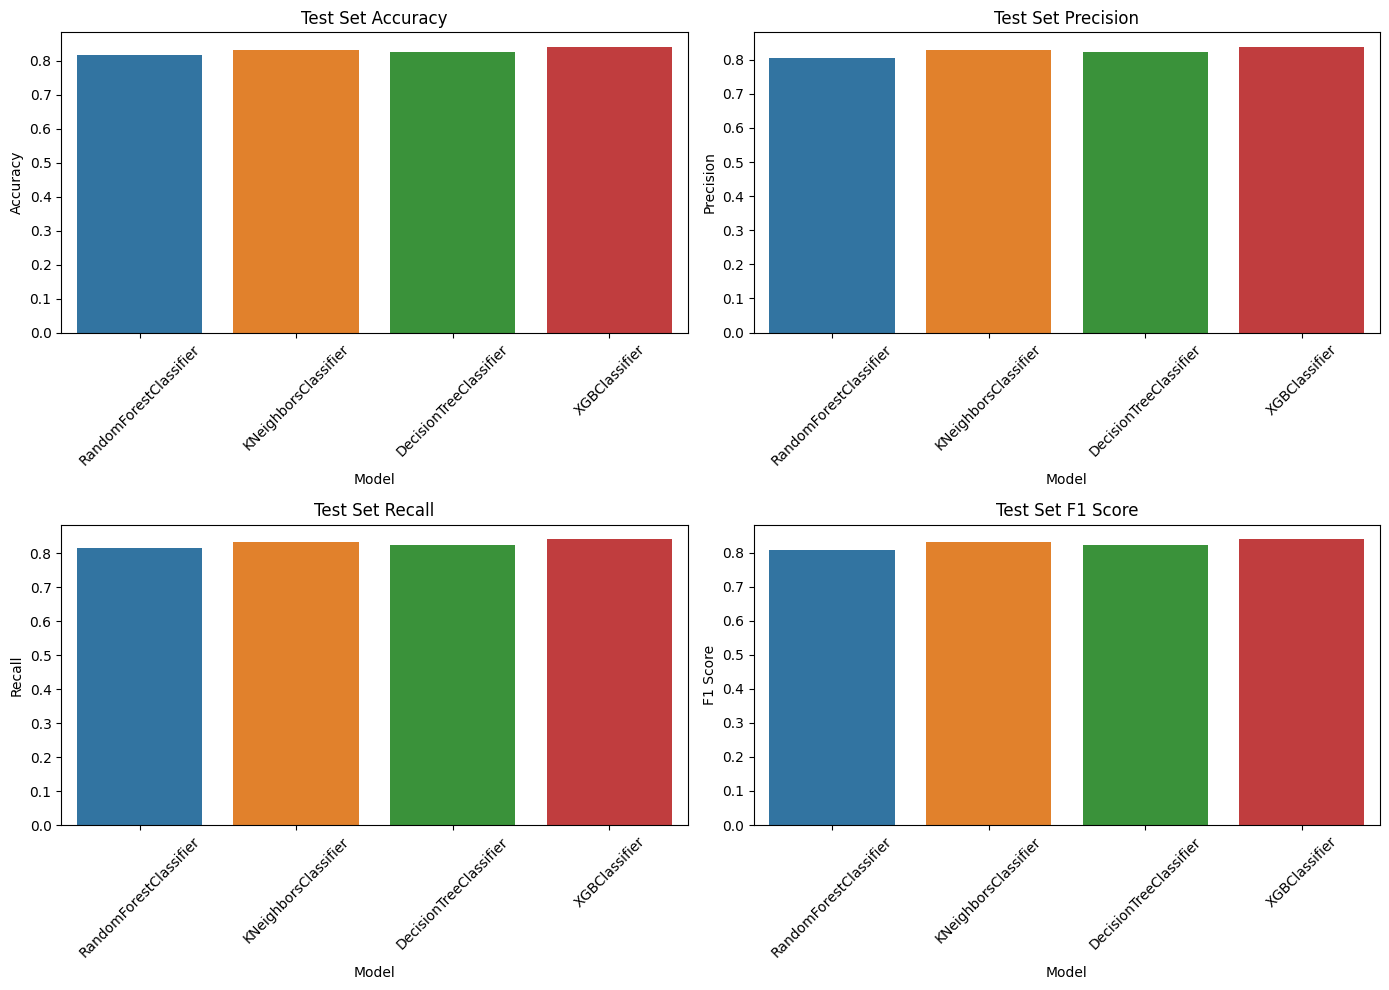

In [39]:
# Initialize lists to store results for test set
test_accuracy_scores = []
test_precision_scores = []
test_recall_scores = []
test_f1_scores = []
test_roc_auc_scores = []
    
# Make predictions and calculate metrics for the test set
y_test_pred_forest = best_model_forest.predict(X_test)
y_test_proba_forest = best_model_forest.predict_proba(X_test)
calculate_and_store_test_metrics("RandomForestClassifier", y_test, y_test_pred_forest)

y_test_pred_knc = best_model_knc.predict(X_test)
y_test_proba_knc = best_model_knc.predict_proba(X_test)
calculate_and_store_test_metrics("KNeighborsClassifier", y_test, y_test_pred_knc)

y_test_pred_dt = best_model_dt.predict(X_test)
y_test_proba_dt = best_model_dt.predict_proba(X_test)
calculate_and_store_test_metrics("DecisionTreeClassifier", y_test, y_test_pred_dt)

y_test_pred_xgb = best_model_xgb.predict(X_test)
y_test_proba_xgb = best_model_xgb.predict_proba(X_test)
calculate_and_store_test_metrics("XGBClassifier", y_test, y_test_pred_xgb)

# Create a DataFrame for easier plotting
test_metrics_df = pd.DataFrame({
    "Model": ["RandomForestClassifier", "KNeighborsClassifier", "DecisionTreeClassifier", "XGBClassifier"],
    "Accuracy": test_accuracy_scores,
    "Precision": test_precision_scores,
    "Recall": test_recall_scores,
    "F1 Score": test_f1_scores,
})

# Plot the test set metrics
plt.figure(figsize=(14, 10))

# Plot Accuracy
plt.subplot(2, 2, 1)
sns.barplot(x="Model", y="Accuracy", data=test_metrics_df)
plt.title("Test Set Accuracy")
plt.xticks(rotation=45)

# Plot Precision
plt.subplot(2, 2, 2)
sns.barplot(x="Model", y="Precision", data=test_metrics_df)
plt.title("Test Set Precision")
plt.xticks(rotation=45)

# Plot Recall
plt.subplot(2, 2, 3)
sns.barplot(x="Model", y="Recall", data=test_metrics_df)
plt.title("Test Set Recall")
plt.xticks(rotation=45)

# Plot F1 Score
plt.subplot(2, 2, 4)
sns.barplot(x="Model", y="F1 Score", data=test_metrics_df)
plt.title("Test Set F1 Score")
plt.xticks(rotation=45)

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

We deduce that, in fact, the `best` model corresponds to the XGBClassifier. 

## Feature importances

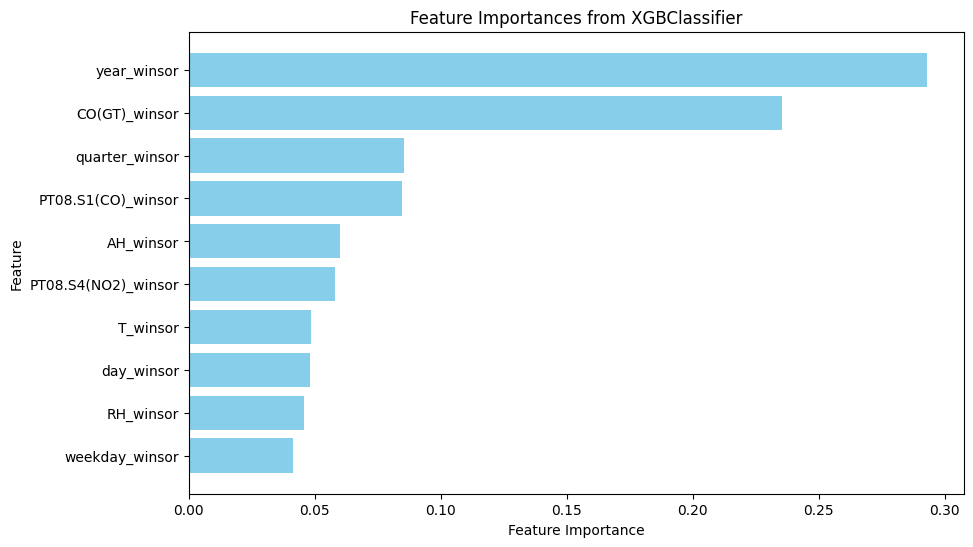

In [40]:
# Assuming best_model_xgb is the trained XGBClassifier model

# Extract feature importances
feature_importances = best_model_xgb.feature_importances_

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': list(X_train.columns),
    'Importance': feature_importances
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from XGBClassifier')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()

## Stacking all the different `best` models

In [41]:
# Define the base classifiers
estimators = [
    ('rf', RandomForestClassifier(**best_params_forest, random_state=RANDOM_SEED)),
    ('knr', KNeighborsClassifier(**best_params_knc)),
    ('dt', DecisionTreeClassifier(**best_params_dt, random_state=RANDOM_SEED)),
    ('xgb', XGBClassifier(**best_params_xgb, random_state=RANDOM_SEED)),
]

# Define the meta-classifier (e.g., LogisticRegression)
meta_model = LogisticRegression()

# Create the stacking classifier
stacking_classifier = StackingClassifier(estimators=estimators, final_estimator=meta_model, cv=5)
stacking_classifier.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('rf',
                                RandomForestClassifier(max_depth=15,
                                                       max_leaf_nodes=100,
                                                       n_estimators=200,
                                                       random_state=20230916)),
                               ('knr',
                                KNeighborsClassifier(n_neighbors=7,
                                                     weights='distance')),
                               ('dt',
                                DecisionTreeClassifier(max_depth=10,
                                                       max_leaf_nodes=100,
                                                       min_samples_split=5,
                                                       random_state=20230916)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster...
                                              interaction_constraints=None,
                                              learning_rate=0.1, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=7,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=100, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=20230916, ...))],
                   final_estimator=LogisticRegression())

In [42]:
y_validation_pred_stack = stacking_classifier.predict(X_validation)
y_test_pred_stack = stacking_classifier.predict(X_test)

In [43]:
print_classification_metrics(y_validation, y_validation_pred_stack, model_name="Stacking Classifier")
print_classification_metrics(y_test, y_test_pred_stack, model_name="Stacking Classifier")

Stacking Classifier Metrics on Validation Set:
  Accuracy: 0.8439
  Precision: 0.8412
  Recall: 0.8439
  F1 Score: 0.8422
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90      1085
           1       0.62      0.52      0.57       108
           2       0.77      0.78      0.78       492

    accuracy                           0.84      1685
   macro avg       0.76      0.73      0.75      1685
weighted avg       0.84      0.84      0.84      1685

Stacking Classifier Metrics on Validation Set:
  Accuracy: 0.8504
  Precision: 0.8458
  Recall: 0.8504
  F1 Score: 0.8473
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       620
           1       0.65      0.51      0.57        68
           2       0.78      0.75      0.77       248

    accuracy                 

We finally note that we worst performance is associated with the minority class 1: `good`.

# Limitations of Air Quality Models
## Data Quality and Availability:
1. Incomplete data, for example, respect geolocation or vehicular traffic, or devices errors/calibrations can limit the accuracy of predictions.
2. Lack of real-time data integration might affect the responsiveness of the model to sudden changes in air quality.
3. Models might not adequately represent local variations if the spatial resolution is too coarse.
## Possible Improvements
1. Increase the spatial and temporal resolution of models to capture microclimates and rapid changes better.
2. Use localized models for areas with significant human activity to get more accurate predictions for those regions.
3. Include traffic data, industrial output, and even social media data for real-time incident reporting.
4. Use advanced meteorological modeling to better understand and predict the impact of weather conditions.
5. Develop an integrated system that combines air quality data with public health data to directly correlate pollution levels with health outcomes. Different data sources APIs, etc.
6. Implement real-time data processing and predictive analytics to provide immediate warnings and updates.
7. Leverage IoT and edge computing to process data closer to the source, reducing latency.
# Technical requirements
1. We would require MLOps frameworks to put in production such type of models.
2. It would be important to consider a machine learning architecture to integrate the different data sources with the different stages of the production phase.
3. Continuously monitoring of model performance and data distribution.
4. Real-time or near-to-real-time responses, depending of the final bussiness goal, e.g. reduce the bad quality of air by locations, hours, etc.
5. Track the different models in order to mabage the manage machine learning lifecycle;
6. A/B Testing to verify that different models in fact preserve suitable metrics in real-world scenarios;
7. Integration of different data sources;traffic, industrial outputs, and social media.